# Analysis

Import data and conduct experiments to answer questions about ALL/AML correlation

In [1]:
%load_ext autoreload
%autoreload 2

In [197]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from utils import *

In [3]:
%%time
corr_df = load_tsv('/data/archive/compendium/v5/v5_all_by_all.2018-02-04.tsv')
meta_df = load_tsv('/data/archive/compendium/v5/clinical.tsv')
prep_df = load_tsv('~/work/TURG/resources/TreehouseCompendiumSamples_LibraryPrep.tsv')
type_df = pd.read_csv('~/work/TURG/resources/DiseaseAnnotations_2018-04_Labels.csv', sep=',', index_col=1)

CPU times: user 1min 43s, sys: 30 s, total: 2min 13s
Wall time: 2min 13s


In [4]:
sample_A = 'TH01_0121_S01'
sample_B = 'TH01_0123_S01'

### For each, what fraction of top 95% (corr > 0.87) were AML?

In [5]:
def print_distrib(sample_id):
    disease_distrib = diseases_correlated_above_threshold(sample_id, corr_df, type_df)
    print('Sample ID:', sample_id)
    print('Disease distribution among samples with correlation > 0.87:')
    print(disease_distrib)

In [6]:
print_distrib(sample_A)
print()
print_distrib(sample_B)

Sample ID: TH01_0121_S01
Disease distribution among samples with correlation > 0.87:
acute myeloid leukemia              0.743590
acute leukemia                      0.102564
acute lymphoblastic leukemia        0.102564
juvenile myelomonocytic leukemia    0.051282
Name: Diagnosis/Disease, dtype: float64

Sample ID: TH01_0123_S01
Disease distribution among samples with correlation > 0.87:
acute myeloid leukemia          0.590476
acute lymphoblastic leukemia    0.380952
acute leukemia                  0.028571
Name: Diagnosis/Disease, dtype: float64


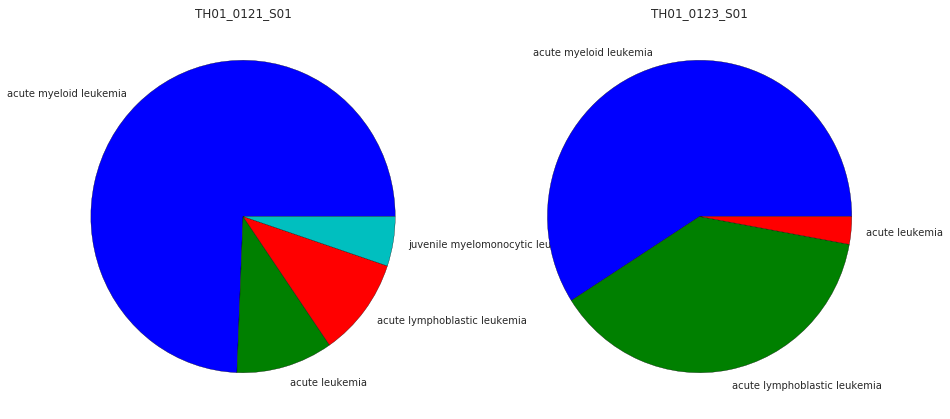

In [7]:
plt.figure(figsize=(15, 7))

plt.subplot(121)
disease_distrib = diseases_correlated_above_threshold(sample_A, corr_df, type_df)
plt.title(sample_A)
plt.pie(disease_distrib, labels=disease_distrib.index)

plt.subplot(122)
disease_distrib = diseases_correlated_above_threshold(sample_B, corr_df, type_df)
plt.title(sample_B)
plt.pie(disease_distrib, labels=disease_distrib.index)

plt.show()

### How correlated are other ALL samples with AML?

Specifically, what impact does RiboD preparation have on their correlation? Use the `type_df` to find ALL samples of interest.

This section is the only one where preparation type matters, as in every other case I search only in the correlation matrix which contains only PolyA-prepared samples.

In [219]:
samples_with_ALL = get_samples_by_disease(ALL, type_df, meta_df)
fracs_aml_all = pd.Series()
fracs_aml_same = pd.Series()
fracs_aml_diff = pd.Series()
sources = pd.Series()
sub_sources = pd.Series()
prep_types = pd.Series()
for sample_id in samples_with_ALL:

    disease_distrib_all = diseases_correlated_above_threshold(sample_id, corr_df, type_df)
    disease_distrib_same = diseases_correlated_above_threshold(sample_id, corr_df, type_df, diff_src=False)
    disease_distrib_diff = diseases_correlated_above_threshold(sample_id, corr_df, type_df, same_src=False)
    if disease_distrib_all is not None:
        fracs_aml_all[sample_id] = disease_distrib_all.get(AML, 0.0)
        fracs_aml_same[sample_id] = disease_distrib_same.get(AML, 0.0)
        fracs_aml_diff[sample_id] = disease_distrib_diff.get(AML, 0.0)

    sample_info = sample_id_info(sample_id)
    sources[sample_id] = sample_info['source']
    sub_sources[sample_id] = sample_info['sub_source']
#     donors[sample_id] = sample_info['donor']

    sample_prep = prep_df.loc[sample_id]['libSelType']
    if type(sample_prep) == pd.Series:
        sample_prep = sample_prep.iloc[0]
    prep_types[sample_id] = sample_prep

samples_df = pd.DataFrame({'frac_AML': fracs_aml_all,
                           'frac_AML_same': fracs_aml_same,
                           'frac_AML_diff': fracs_aml_diff,
                           'source': sources,
                           'sub_source': sub_sources,
                           'prep_type': prep_types})
samples_df.index.name = 'THid'
samples_df = samples_df[pd.notnull(samples_df['frac_AML_same'])]

Number of donors missing from file structure: 150


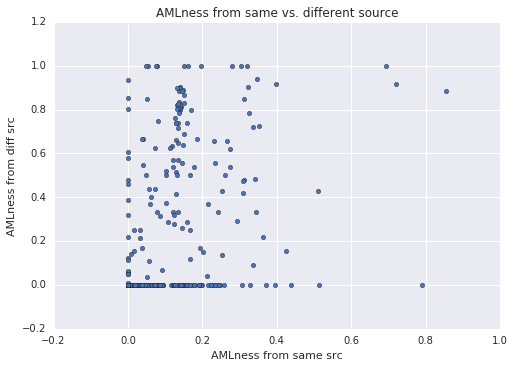

In [227]:
# samples_df_thr = samples_df
# samples_df_thr = samples_df.loc[samples_df['source'] == 'TARGET']
# samples_df_thr = samples_df.loc[samples_df['source'] == 'THR'].loc[samples_df['sub_source'] == '08']
palette = sb.color_palette(n_colors=10)
for i, subsrc in enumerate(samples_df['sub_source'].unique()):
    samples_df_thr = samples_df.loc[samples_df['sub_source'] == subsrc]
    plt.scatter(samples_df_thr['frac_AML_same'], samples_df_thr['frac_AML_diff'], c=palette[0])
plt.title('AMLness from same vs. different source')
plt.xlabel('AMLness from same src')
plt.ylabel('AMLness from diff src')
plt.show()

In [238]:
samples_df.loc[samples_df['source'] == 'TARGET'].sort_values(by=['frac_AML_same'], ascending=True).head(20)

,frac_AML,frac_AML_diff,frac_AML_same,prep_type,source,sub_source
THid,,,,,,
TARGET-10-PATTEE-03,0.000000,0.000000,0.0,polyASelection,TARGET,TARGET-10
TARGET-10-PARLAF-09,0.000000,0.000000,0.0,polyASelection,TARGET,TARGET-10
TARGET-10-PARIAD-04,0.000000,0.000000,0.0,polyASelection,TARGET,TARGET-10
TARGET-10-PANSHK-04,0.000000,0.000000,0.0,polyASelection,TARGET,TARGET-10
TARGET-10-PANSIA-09,0.000000,0.000000,0.0,polyASelection,TARGET,TARGET-10
TARGET-10-PARFTR-04,0.000000,0.000000,0.0,polyASelection,TARGET,TARGET-10
TARGET-10-PAPRFE-09,0.000000,0.000000,0.0,polyASelection,TARGET,TARGET-10
TARGET-10-PANWHW-09,0.000000,0.000000,0.0,polyASelection,TARGET,TARGET-10
TARGET-10-PANYEJ-09,0.000000,0.000000,0.0,polyASelection,TARGET,TARGET-10


In [239]:
sid = 'TARGET-10-PATTEE-03'

In [240]:
s_corr_dict = get_sample_correlations(sid, corr_df)
s_sample_corrs = pd.Series(s_corr_dict)

In [241]:
s_sample_sources = pd.Series()
s_sample_diseases = pd.Series()
for s in s_sample_corrs.index:
    s_sample_sources[s] = sample_to_source(s)
    s_sample_diseases[s] = meta_df['disease'].loc[s]

In [242]:
s_sample_df = pd.DataFrame({'corr': s_sample_corrs, 'source': s_sample_sources, 'disease': s_sample_diseases})

In [245]:
s_sample_df.sort_values(by=['corr'])

,corr,disease,source
THR11_0271_S01,0.577464,glioma,THR
THR11_0274_S01,0.586902,glioma,THR
THR11_0269_S01,0.592520,glioma,THR
THR20_0503_S01,0.593996,medulloblastoma,THR
TH02_0080_S01,0.594651,glioma,TH
TH02_0078_S01,0.601344,glioma,TH
THR20_0509_S01,0.604215,medulloblastoma,THR
TCGA-B4-5832-01,0.608341,kidney clear cell carcinoma,TCGA
THR11_0248_S01,0.612319,glioma,THR
TCGA-CZ-5989-01,0.612501,kidney clear cell carcinoma,TCGA


In [243]:
s_sample_df.loc[s_sample_df['source'] == 'THR'].loc[s_sample_df['corr'] > 0.87].sort_values(by=['corr'], ascending=False)['disease'].value_counts()

Series([], Name: disease, dtype: int64)

In [229]:
def plot_correlations(suptitle, same_src=True, diff_src=True):
    samples_with_ALL = get_samples_by_disease(ALL, type_df, meta_df)
    fracs_aml = pd.Series()
    sources = pd.Series()
    prep_types = pd.Series()
    for sample_id in samples_with_ALL:

        disease_distrib = diseases_correlated_above_threshold(sample_id, corr_df, type_df,
                                                              same_src=same_src, diff_src=diff_src)
        if disease_distrib is not None:
            fracs_aml[sample_id] = disease_distrib[AML] if AML in disease_distrib else 0.0

        source = sample_to_source(sample_id)
        sources[sample_id] = source

        sample_prep = prep_df.loc[sample_id]['libSelType']
        if type(sample_prep) == pd.Series:
            sample_prep = sample_prep.iloc[0]
        prep_types[sample_id] = sample_prep
    
    samples_df = pd.DataFrame({'frac_AML': fracs_aml, 'source': sources, 'prep_type': prep_types})
    samples_df.index.name = 'THid'
    samples_df = samples_df[pd.notnull(samples_df['frac_AML'])]
    
    # plot results
    plt.figure(figsize=(15, 20))
    plt.suptitle(suptitle)

    palette = sb.color_palette(n_colors=10)
    color_1 = palette[0]
    color_2 = palette[2]

    plt.subplot(421)
    criterion = samples_df['prep_type'] == 'riboDepletion'
    plot_criterion(samples_df, criterion, title='All sources, riboDepletion', color=color_1)

    plt.subplot(422)
    criterion = samples_df['prep_type'] == 'polyASelection'
    plot_criterion(samples_df, criterion, title='All sources, polyASelection', color=color_2)

    plt.subplot(423)
    criterion = (samples_df['source'] == 'TARGET') & (samples_df['prep_type'] == 'riboDepletion')
    plot_criterion(samples_df, criterion, title='TARGET, riboDepletion', color=color_1)

    plt.subplot(424)
    criterion = (samples_df['source'] == 'TARGET') & (samples_df['prep_type'] == 'polyASelection')
    plot_criterion(samples_df, criterion, title='TARGET, polyASelection', color=color_2)

    plt.subplot(425)
    criterion = (samples_df['source'] == 'TH') & (samples_df['prep_type'] == 'riboDepletion')
    plot_criterion(samples_df, criterion, title='TH, riboDepletion', color=color_1)

    plt.subplot(426)
    criterion = (samples_df['source'] == 'TH') & (samples_df['prep_type'] == 'polyASelection')
    plot_criterion(samples_df, criterion, title='TH, polyASelection', color=color_2)

    plt.subplot(427)
    criterion = (samples_df['source'] == 'THR') & (samples_df['prep_type'] == 'riboDepletion')
    plot_criterion(samples_df, criterion, title='THR, riboDepletion', color=color_1)

    plt.subplot(428)
    criterion = (samples_df['source'] == 'THR') & (samples_df['prep_type'] == 'polyASelection')
    plot_criterion(samples_df, criterion, title='THR, polyASelection', color=color_2)

    plt.show()

In [85]:
def plot_criterion(df, criterion=None, title=None, range=(0, 1), color='blue', alpha=1.0, label=''):
    src_df = df if criterion is None else df.loc[criterion]
    plt.hist(src_df['frac_AML'], bins=30, range=range, color=color, alpha=alpha, label=label)
    if title is not None:
        plt.title(title)
    plt.xlabel('Frac AML')
    plt.ylabel('Freq')

Number of donors missing from file structure: 150


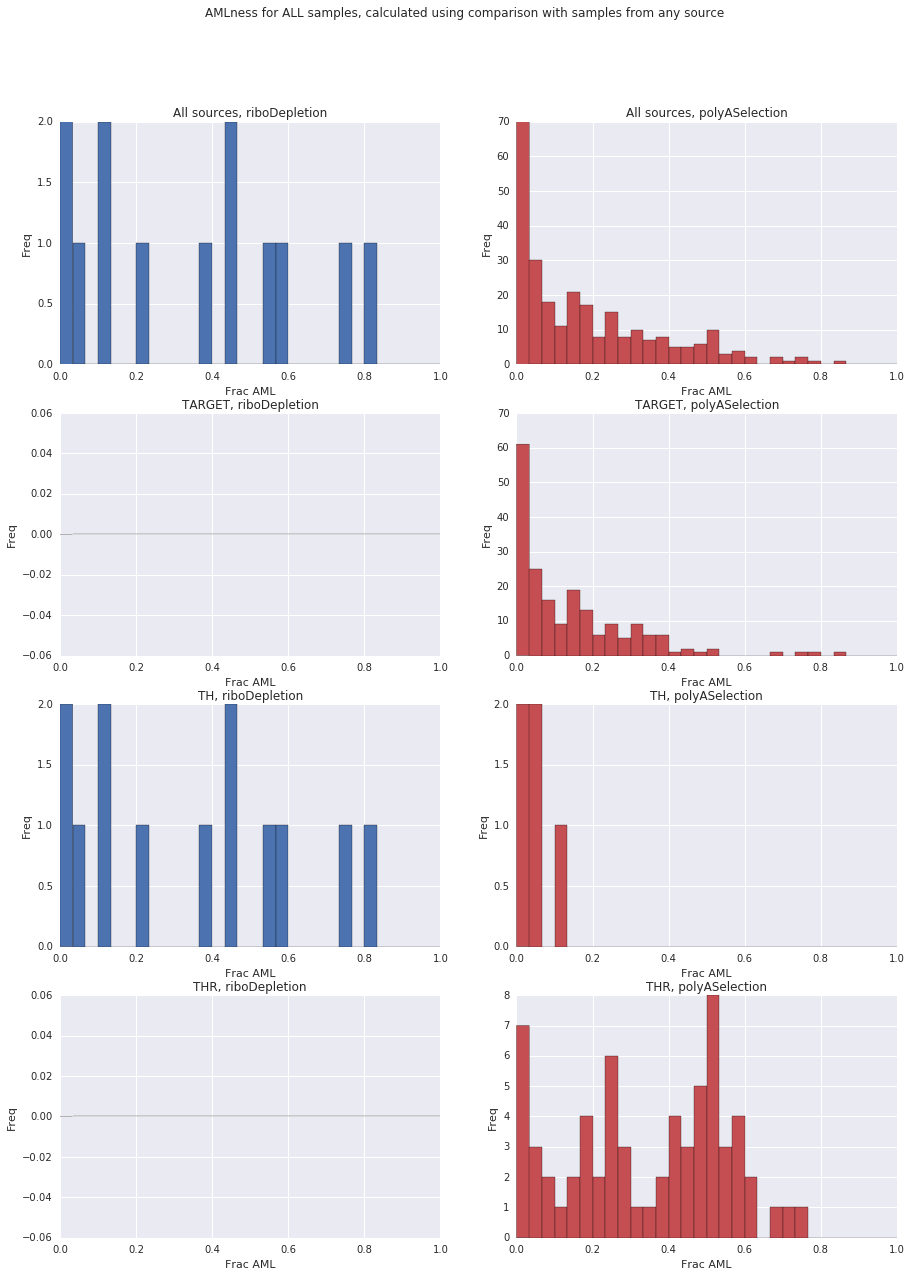

CPU times: user 10 s, sys: 2.13 s, total: 12.2 s
Wall time: 10.3 s


In [230]:
%%time
plot_correlations(suptitle='AMLness for ALL samples, calculated using comparison with samples from any source')

Number of donors missing from file structure: 150


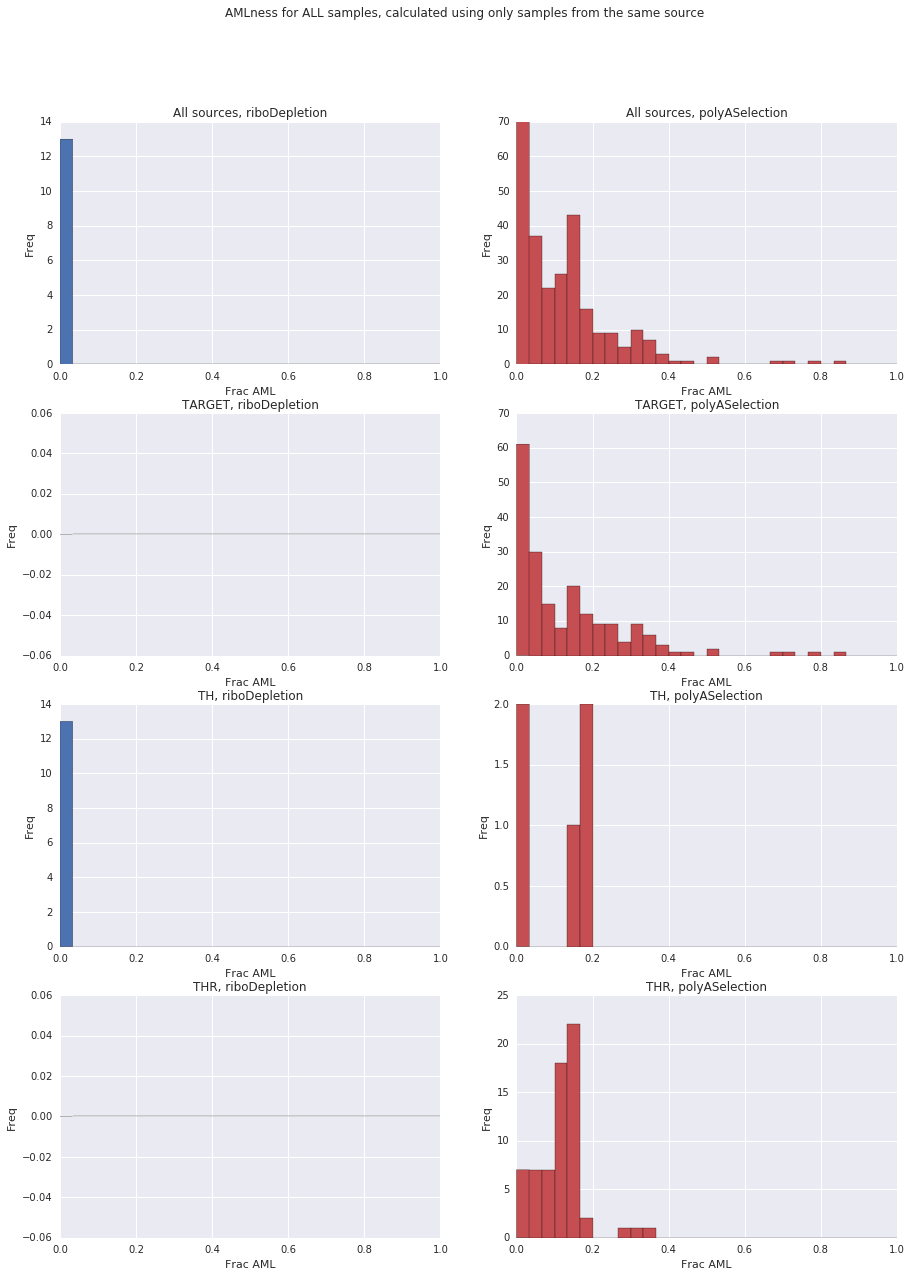

CPU times: user 11 s, sys: 0 ns, total: 11 s
Wall time: 9.12 s


In [94]:
%%time
plot_correlations(diff_src=False,
                  suptitle='AMLness for ALL samples, calculated using only samples from the same source')

### Find the samples of any type that are most correlated with AML

In [89]:
%%time
threshold = 0.3
fracs_aml = pd.Series()
diseases = pd.Series()
for sample_id in corr_df.index:
    disease_distrib = diseases_correlated_above_threshold(sample_id, corr_df, type_df, same_src=True)
    frac_aml = disease_distrib[AML] if AML in disease_distrib else 0
    if frac_aml > threshold:
        fracs_aml[sample_id] = frac_aml
        donor_id = sample_to_donor(sample_id)
        disease = type_df.loc[donor_id]['Diagnosis/Disease']
        diseases[sample_id] = disease

CPU times: user 3min 31s, sys: 0 ns, total: 3min 31s
Wall time: 3min 31s


In [90]:
amlish_df = pd.DataFrame({'frac_AML': fracs_aml, 'disease': diseases})
amlish_df.index.name = 'THid'

Distribution of diseases in highly correlated to AML samples:


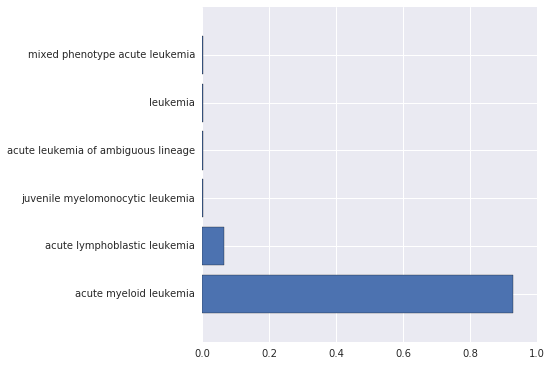

In [91]:
print('Distribution of diseases in highly correlated to AML samples:')
disease_distrib = amlish_df['disease'].value_counts() / len(amlish_df)

plt.figure(figsize=(6, 6))
plt.barh(range(len(disease_distrib)), disease_distrib, align='center')
plt.yticks(range(len(disease_distrib)), disease_distrib.index)
# plt.pie(disease_distrib, labels=disease_distrib.index)
plt.show()

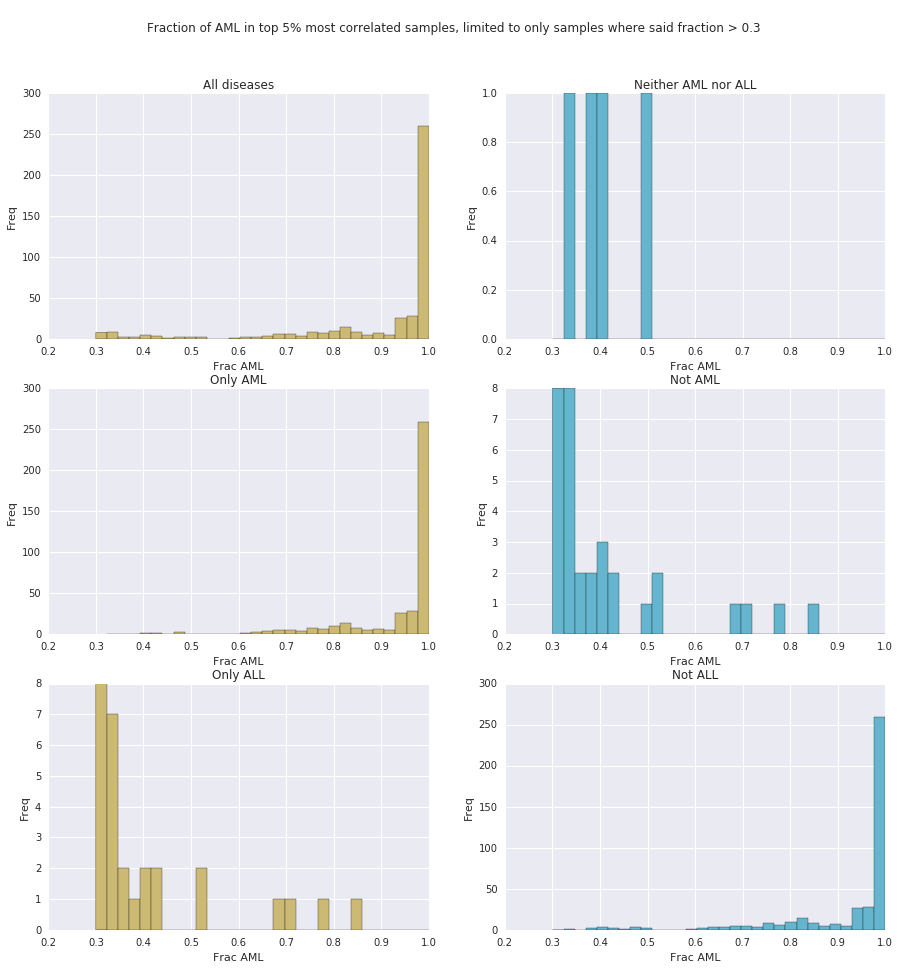

In [92]:
plt.figure(figsize=(15, 15))
suptitle = """
Fraction of AML in top 5% most correlated samples, limited to only samples where said fraction > 0.3
"""
plt.suptitle(suptitle)

palette = sb.color_palette(n_colors=10)
color_1 = palette[4]
color_2 = palette[5]

not_AML = amlish_df['disease'] != AML
not_ALL = amlish_df['disease'] != ALL

plt.subplot(321)
plot_criterion(amlish_df, title='All diseases', range=(0.3, 1), color=color_1)

plt.subplot(322)
plot_criterion(amlish_df, not_AML & not_ALL, title='Neither AML nor ALL', range=(0.3, 1), color=color_2)

plt.subplot(323)
plot_criterion(amlish_df, ~not_AML, title='Only AML', range=(0.3, 1), color=color_1)

plt.subplot(324)
plot_criterion(amlish_df, not_AML, title='Not AML', range=(0.3, 1), color=color_2)

plt.subplot(325)
plot_criterion(amlish_df, ~not_ALL, title='Only ALL', range=(0.3, 1), color=color_1)

plt.subplot(326)
plot_criterion(amlish_df, not_ALL, title='Not ALL', range=(0.3, 1), color=color_2)

plt.show()